In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary

In [2]:
data = np.random.randint(-10, 11, (10000, 2))

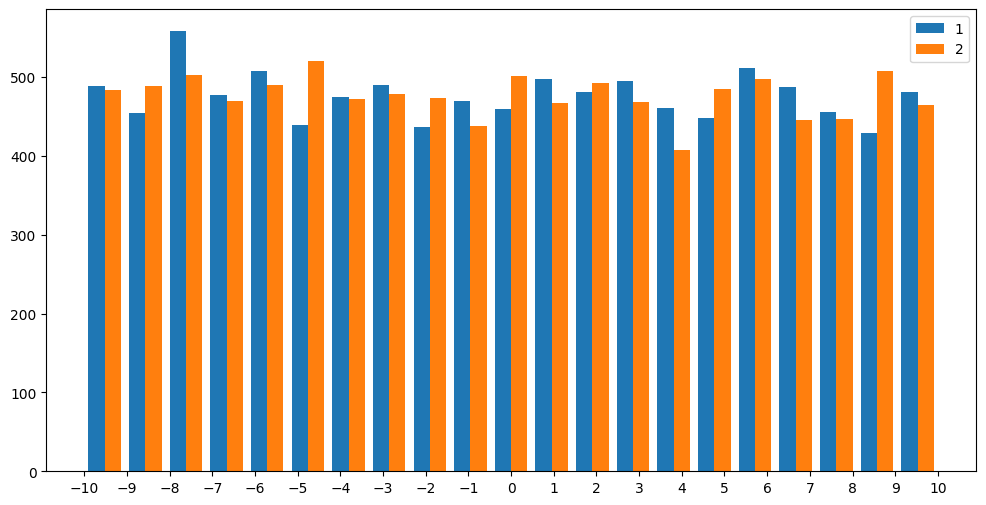

In [3]:
plt.figure(figsize=(12, 6))
plt.hist(data, bins=21, label=["1", "2"])
plt.legend()
plt.xticks(np.arange(-10, 11))
plt.show()

In [4]:
labels = data[:, 0] + data[:, 1]
labels.shape

(10000,)

# Convert ndarray to torch Tensor

In [19]:
train_data, test_data, train_labels, test_labels = [
    torch.tensor(array).float()
    for array in train_test_split(data, labels, test_size=0.1)
]
train_data.shape, test_data.shape, train_labels.shape, test_labels.shape

(torch.Size([9000, 2]),
 torch.Size([1000, 2]),
 torch.Size([9000]),
 torch.Size([1000]))

In [20]:
BATCH_SIZE = 32

train_dataset = TensorDataset(train_data, train_labels.unsqueeze(dim=1))
test_dataset = TensorDataset(test_data, test_labels.unsqueeze(dim=1))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True
)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [21]:
X, y = next(iter(train_dataloader))
X.dtype, y.dtype

(torch.float32, torch.float32)

In [22]:
X.shape, y.shape

(torch.Size([32, 2]), torch.Size([32, 1]))

# Create the model

In [23]:
class FFN(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_units: int,
        n_hd_layers: int,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)
        self.n_hd_layers = n_hd_layers
        self.layers = nn.ModuleDict()
        self.layers["input"] = nn.Linear(in_features, hidden_units)

        for i in range(self.n_hd_layers):
            self.layers[f"hidden{i}"] = nn.Linear(hidden_units, hidden_units)

        self.layers["output"] = nn.Linear(hidden_units, out_features)

    def forward(self, x):
        x = torch.relu(self.layers["input"](x))

        for i in range(self.n_hd_layers):
            x = torch.relu(self.layers[f"hidden{i}"](x))

        return self.layers["output"](x)

In [24]:
model = FFN(2, 1, 10, 5)
summary(
    model,
    input_size=[BATCH_SIZE, 2],
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
FFN                                      [32, 2]                   [32, 1]                   --
├─ModuleDict: 1-1                        --                        --                        --
│    └─Linear: 2-1                       [32, 2]                   [32, 10]                  30
│    └─Linear: 2-2                       [32, 10]                  [32, 10]                  110
│    └─Linear: 2-3                       [32, 10]                  [32, 10]                  110
│    └─Linear: 2-4                       [32, 10]                  [32, 10]                  110
│    └─Linear: 2-5                       [32, 10]                  [32, 10]                  110
│    └─Linear: 2-6                       [32, 10]                  [32, 10]                  110
│    └─Linear: 2-7                       [32, 10]                  [32, 1]                   11
Total params: 591
Trainable pa

# Train the model

In [34]:
model = FFN(in_features=2, out_features=1, n_hd_layers=5, hidden_units=10)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 10
losses = np.zeros((epochs, 2))

for epoch in range(epochs):
    train_batch_loss = np.zeros(len(train_dataloader))
    test_batch_loss = np.zeros(len(test_dataloader))

    model.train()
    for i, (X, y) in enumerate(train_dataloader):
        y_hat = model(X)
        loss = loss_fn(y_hat, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_batch_loss[i] = loss.item()

    model.eval()
    with torch.inference_mode():
        for i, (X, y) in enumerate(test_dataloader):
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_batch_loss[i] = loss.item()

    losses[epoch, 0] = np.mean(train_batch_loss)
    losses[epoch, 1] = np.mean(test_batch_loss)

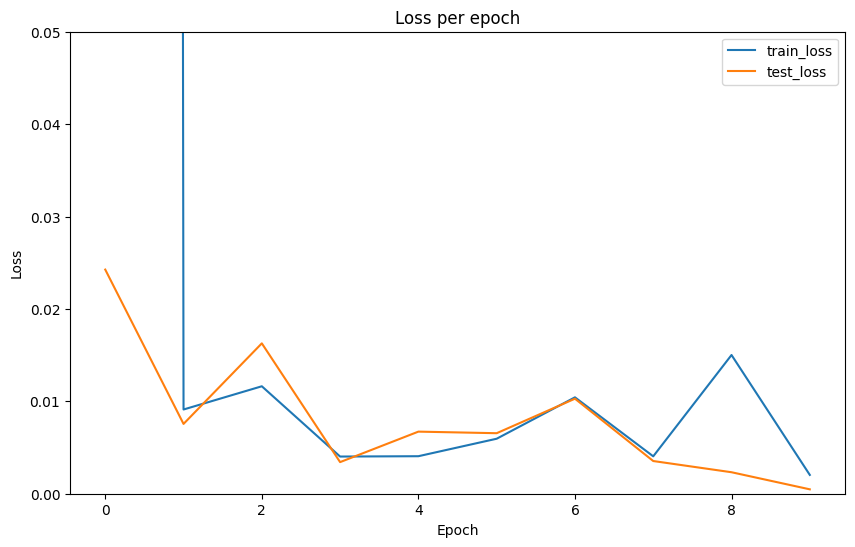

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
line1, line2 = ax.plot(losses)
ax.legend([line1, line2], ["train_loss", "test_loss"])
ax.set_title("Loss per epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 0.05])
plt.show()

In [51]:
with torch.inference_mode():
    test_data = torch.tensor([-10, 7]).float()
    pred = model(test_data)
    print(pred)

tensor([-3.1084])
